In [3]:
import sys
import numpy as np
sys.path.append('../../')
from settings import paths, stats
from utils import get_proteins
from containers import Protein

import matplotlib.pyplot as plt
%matplotlib inline

/Users/jpaggi/sherlock/combind_code/schrodinger_local.ve/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jpaggi/sherlock/combind_code/schrodinger_local.ve/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
_paths = {}
for k, v in paths.items():
    _paths[k] = v.replace('/oak/stanford/groups/rondror', '/Users/jpaggi/sherlock/oak')
paths = _paths

rmsds, gscores = [], []
for protein in get_proteins(paths, []):
    prot = Protein(protein, stats['stats104'], paths)
    ligands = prot.lm.get_xdocked_ligands(20)
    print(prot.lm.path('PDB'))
    print(ligands)
    prot.load_docking(ligands)
    for ligand in ligands:
        for pose in prot.docking[prot.lm.st][ligand].poses[:100]:
            rmsds += [pose.rmsd]
            gscores += [pose.gscore]
rmsds, gscores = np.array(rmsds), np.array(gscores)
len(gscores)

/Users/jpaggi/sherlock/oak/users/jpaggi/combind/B2AR/structures/pdb.csv
['3D4S_lig', '3NY8_lig', '3NY9_lig', '3NYA_lig', '3P0G_lig', '4LDL_lig', '4LDO_lig']
/Users/jpaggi/sherlock/oak/users/jpaggi/combind/Q05586-Q12879/structures/pdb.csv
['5H8N_lig', '5H8Q_lig', '5I2K_lig', '5I2N_lig', '5KCJ_lig', '5KDT_lig', '5TP9_lig', '5TPA_lig']
/Users/jpaggi/sherlock/oak/users/jpaggi/combind/B1AR/structures/pdb.csv
['2Y00_lig', '2Y02_lig', '2Y03_lig', '2Y04_lig', '2YCW_lig', '2YCZ_lig', '3ZPQ_lig', '3ZPR_lig', '4AMI_lig', '4AMJ_lig', '5A8E_lig']
/Users/jpaggi/sherlock/oak/users/jpaggi/combind/DAT/structures/pdb.csv
['4XNU_lig', '4XNX_lig', '4XP1_lig', '4XP4_lig', '4XP5_lig', '4XP6_lig', '4XP9_lig', '4XPA_lig']
/Users/jpaggi/sherlock/oak/users/jpaggi/combind/PLAU/structures/pdb.csv
['1C5Y_lig', '1C5Z_lig', '1EJN_lig', '1F5L_lig', '1GI7_lig', '1GJ7_lig', '1GJ8_lig', '1GJA_lig', '1GJC_lig', '1GJD_lig', '1O3P_lig', '1O5A_lig', '1O5C_lig', '1OWE_lig', '1OWH_lig', '1SQA_lig', '1SQO_lig', '1SQT_lig', '1W

37874

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(gscores.reshape(-1, 1), rmsds < 2.0)
lr.coef_, lr.intercept_

(array([[-0.8828839]]), array([-7.46918161]))

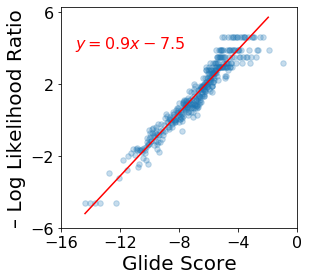

In [44]:
sorted_rmsds = rmsds[gscores.argsort()]
sorted_gscores = gscores[gscores.argsort()]

N = 100
x, y = [], []
for i in range(0, len(sorted_gscores), N):
    _x = sorted_gscores[i:i+N]
    _y = sorted_rmsds[i:i+N] < 2.0
    x += [_x.mean()]
    y += [- np.log((1+(_y == 1).sum()) / (1+(_y == 0).sum()))]

plt.figure(figsize = (4.4, 4))
plt.scatter(x, y, alpha = 0.25, s = 30)

x = np.linspace(x[0], x[-1]-1, 100)
y = -lr.coef_[0][0] * x - lr.intercept_[0]
plt.plot(x, y, c = 'r')

plt.xlim(-15, 0)

plt.text(-15, 4, r'$y = {}x {}$'.format(round(-lr.coef_[0][0], 1), round(+lr.intercept_[0], 1)),
         fontsize=16, c = 'r')
plt.yticks(plt.yticks()[0][::2], size = 16)
plt.xticks(plt.xticks()[0][::2], size = 16)
plt.ylabel('– Log Likelihood Ratio', size=20)
plt.xlabel('Glide Score', size=20)
plt.tight_layout()
plt.savefig('../../pymol/figures/gscore_callibration.pdf')
plt.show()